# SETUP

In [1]:
import sys
sys.path.insert(0,'..')
from medzoo_imports import create_model, DiceLoss, Trainer
from os import listdir
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from data_generators.data_loader import SegmentationDataSet, sliding_window
import torchhttp://localhost:8888/notebooks/HISourceFinder/notebooks/Inference.ipynb#
from astropy.io import fits
import numpy as np
from astropy.visualization import ZScaleInterval, ImageNormalize
import matplotlib.pyplot as plt
import pandas as pd
import torch.backends.cudnn as cudnn
from matplotlib.cm import register_cmap


Properties of pre-trained model

In [14]:
batch_size=1
dataset_name="hi_data"
root = '../'
dim=(64, 64, 64)
nEpochs=10
classes=1
inChannels=1
terminal_show_freq=50
model='VNET'
opt='sgd'
log_dir='../runs/'
lr = 1e-2
dims = [128, 128, 64]
overlaps = [15, 20, 20]
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 2}

save = ('../saved_models/' + model + '_checkpoints/' + model + '_', dataset_name)[0]

Load pre-trained model

In [36]:
class argsclass:
    def __init__(self, model, opt, lr, inChannels, classes, pretrained):
        self.model = model
        self.opt=opt
        self.lr=lr
        self.inChannels=1
        self.classes=1
        self.cuda = False
        self.pretrained = pretrained
        self.dataset_name = 'hi_source'
        self.save = '../inference_checkpoints/' + self.model + '_checkpoints/' + self.model + '_' + self.dataset_name
args = argsclass('VNET', 'adam', 1e-2, 1, 1, "../saved_models/VNET_checkpoints/VNET_/VNET__last_epoch.pth")
model, optimizer = create_model(args)
criterion = DiceLoss(classes=args.classes)
model.restore_checkpoint(args.pretrained)

Building Model . . . . . . . .VNET
VNET Number of params: 45599926


8

In [89]:
train_df = pd.read_csv("../saved_models/VNET_checkpoints/VNET_/train.csv", header=None, sep=" ", names=["skip", "epoch", "loss", "dsc"])
val_df = pd.read_csv("../saved_models/VNET_checkpoints/VNET_/val.csv", header=None, sep=" ", names=["skip", "epoch", "loss", "dsc"])

In [90]:
val_df["loss"] = val_df.loss.str.split(":", expand=True)[1]
train_df["loss"] = train_df.loss.str.split(":", expand=True)[1]
val_df["dsc"] = val_df.dsc.str.split(":", expand=True)[1]
train_df["dsc"] = train_df.dsc.str.split(":", expand=True)[1]
train_df = train_df[['epoch', 'loss', 'dsc']]
val_df = val_df[['epoch', 'loss', 'dsc']]

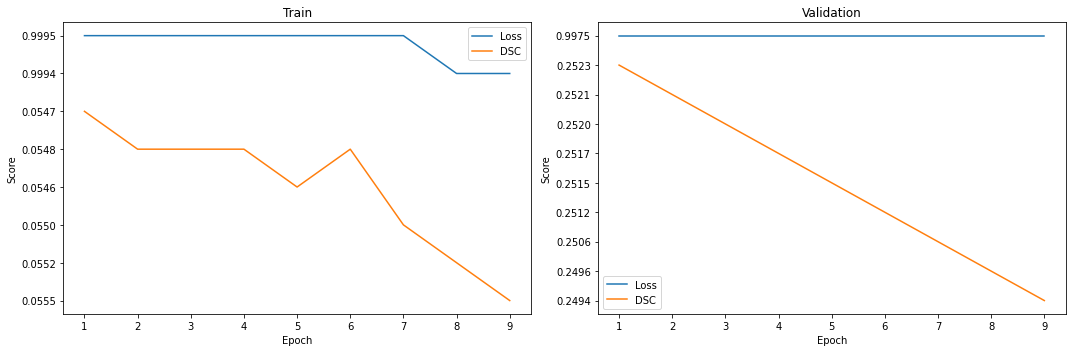

In [123]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
axes[0].set_title("Train")
axes[0].plot(train_df.epoch, train_df.loss, label="Loss")
axes[0].plot(train_df.epoch, train_df.dsc, label="DSC")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Score")

axes[1].set_title("Validation")
axes[1].plot(val_df.epoch, val_df.loss, label="Loss")
axes[1].plot(val_df.epoch, val_df.dsc, label="DSC")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Score")

axes[0].invert_yaxis()
axes[1].invert_yaxis()
axes[0].legend()
axes[1].legend()
fig.tight_layout()

# TEST ON SCALED NOISE FREE CUBE

Load the test subcubes

80
done subcubes
done masks


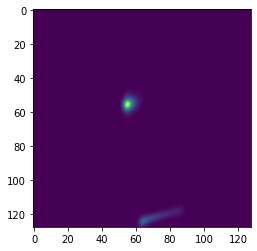

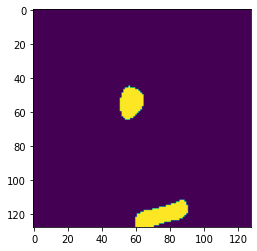

In [127]:
# dataset training
dataset_train = SegmentationDataSet(inputs=['test_cube.fits'],
                                    targets=['test_seg.fits'],
                                    dims=dims,
                                    overlaps=overlaps,
                                    load=False,
                                    root='./',
                                    mode="train")

getdata = dataset_train.__getitem__(1)
view_x, view_y = getdata[0].squeeze().numpy(), getdata[1].squeeze().numpy()
plt.imshow(view_x[:, :, 10])
plt.show()
plt.imshow(view_y[:, :, 10])
plt.show()

Load through like training data and test still the same

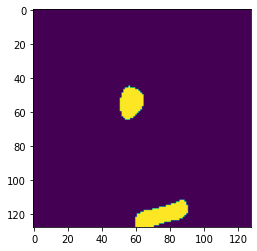

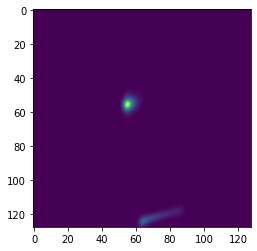

torch.Size([1, 1, 128, 128, 64])

In [128]:
dataloader_training = DataLoader(dataset=dataset_train, **params)
for i, img_tensor in enumerate(dataloader_training):
    data_loader_tensor = img_tensor[0]
    data_loader_mask = img_tensor[1]
    plt_im = data_loader_mask.view(1, 128, 128, 64).squeeze().numpy()[..., 10]
    if (view_y[:, :, 10] == plt_im).all():
        plt.imshow(plt_im)
        plt.show()
        plt.imshow(data_loader_tensor.view(1, 128, 128, 64).squeeze().numpy()[..., 10])
        plt.show()
        break
data_loader_mask.shape

Run inference on test subcube and mask

In [129]:
model.eval()
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)
    out_mask = model.inference(data_loader_mask)
# full_vol_prediction = out.view(1, 128, 128, 64)
# _, indices = full_vol_prediction.max(dim=0)
# out_softmax = torch.softmax(out, dim=0)

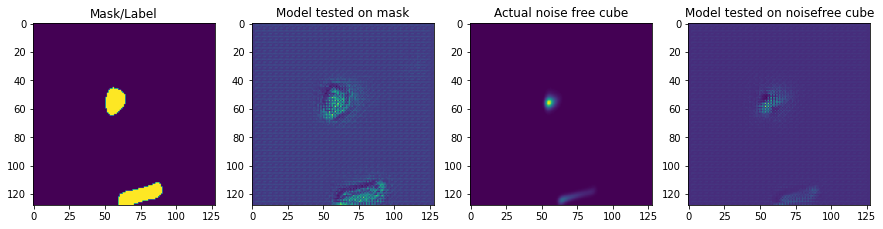

In [130]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15))
axes[0].imshow(data_loader_mask.squeeze()[..., 10])
axes[0].set_title("Mask/Label")
axes[1].imshow(out_mask.squeeze()[..., 10])
axes[1].set_title("Model tested on mask")
axes[2].imshow(data_loader_tensor.squeeze()[..., 10])
axes[2].set_title("Actual noise free cube")
axes[3].imshow(out_cube.squeeze()[..., 10])
axes[3].set_title("Model tested on noisefree cube")
plt.show()

# TEST ON SCALED NOISEY CUBE

Load the test subcubes

80
done subcubes
done masks


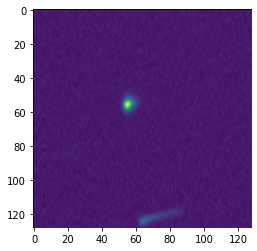

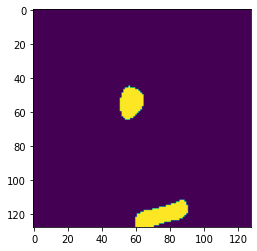

In [131]:
# dataset training
dataset_train = SegmentationDataSet(inputs=['test_noisey_cube.fits'],
                                    targets=['test_seg.fits'],
                                    dims=dims,
                                    overlaps=overlaps,
                                    load=False,
                                    root='./',
                                    mode="train")

getdata = dataset_train.__getitem__(1)
view_x, view_y = getdata[0].squeeze().numpy(), getdata[1].squeeze().numpy()
plt.imshow(view_x[:, :, 10])
plt.show()
plt.imshow(view_y[:, :, 10])
plt.show()

Load through like training data and test still the same

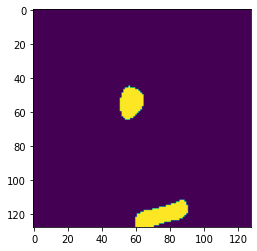

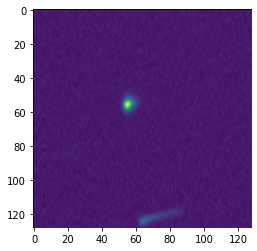

torch.Size([1, 1, 128, 128, 64])

In [132]:
dataloader_training = DataLoader(dataset=dataset_train, **params)
for i, img_tensor in enumerate(dataloader_training):
    data_loader_tensor = img_tensor[0]
    data_loader_mask = img_tensor[1]
    plt_im = data_loader_mask.view(1, 128, 128, 64).squeeze().numpy()[..., 10]
    if (view_y[:, :, 10] == plt_im).all():
        plt.imshow(plt_im)
        plt.show()
        plt.imshow(data_loader_tensor.view(1, 128, 128, 64).squeeze().numpy()[..., 10])
        plt.show()
        break
data_loader_mask.shape

Run inference on test subcube and mask

In [133]:
model.eval()
with torch.no_grad():
    out_cube = model.inference(data_loader_tensor)
    out_mask = model.inference(data_loader_mask)
# full_vol_prediction = out.view(1, 128, 128, 64)
# _, indices = full_vol_prediction.max(dim=0)
# out_softmax = torch.softmax(out, dim=0)

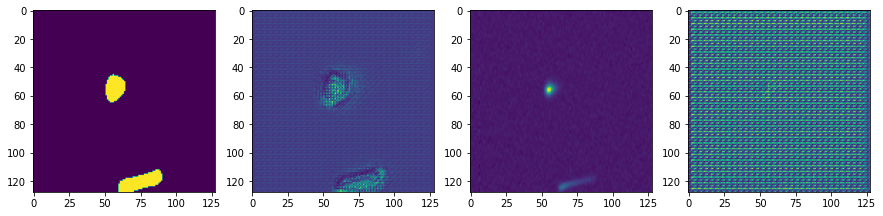

In [134]:
fig, axes = plt.subplots(1, 4, figsize=(15, 15))
axes[0].imshow(data_loader_mask.squeeze()[..., 10])
axes[1].imshow(out_mask.squeeze()[..., 10])
axes[2].imshow(data_loader_tensor.squeeze()[..., 10])
axes[3].imshow(out_cube.squeeze()[..., 10])